In [23]:
# 01_eda_and_labels.ipynb — Step 1: load FD001 and create RUL labels

import os, re
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

pd.set_option("display.max_columns", 200)
plt.rcParams["figure.figsize"] = (8,5)

DATA_DIR = "Projects/NASA_TurboFan_RUL/data/FD001"
RNG = 42

# Column names: unit, cycle, 3 settings, 21 sensors
COLS = ["unit", "cycle", "setting1", "setting2", "setting3"] + [f"s{i}" for i in range(1,22)]


In [41]:
COLS = ["unit", "cycle", "setting1", "setting2", "setting3"] + [f"s{i}" for i in range(1,22)]

def load_fd(path_train, path_test, path_rul):
    for p in (path_train, path_test, path_rul):
        if not Path(p).exists():
            raise FileNotFoundError(f"File not found: {p}")
    train = pd.read_csv(path_train, sep=r"\s+", header=None)
    test  = pd.read_csv(path_test,  sep=r"\s+", header=None)
    rul   = pd.read_csv(path_rul,   sep=r"\s+", header=None)
    if train.shape[1] > 26: train = train.iloc[:, :26]
    if test.shape[1]  > 26: test  = test.iloc[:,  :26]
    train.columns = COLS; test.columns = COLS; rul.columns = ["RUL"]
    return train, test, rul

train_raw, test_raw, rul = load_fd(
    DATA_DIR / "train_FD001.txt",
    DATA_DIR / "test_FD001.txt",
    DATA_DIR / "RUL_FD001.txt",
)

print(train_raw.shape, test_raw.shape, rul.shape)
train_raw.head()


(20631, 26) (13096, 26) (100, 1)


,unit,cycle,setting1,setting2,setting3,s1,s2,s3,s4,s5,s6,s7,s8,s9,s10,s11,s12,s13,s14,s15,s16,s17,s18,s19,s20,s21
0,1,1,-0.0007,-0.0004,100.0,518.67,641.82,1589.70,1400.60,14.62,21.61,554.36,2388.06,9046.19,1.3,47.47,521.66,2388.02,8138.62,8.4195,0.03,392,2388,100.0,39.06,23.4190
1,1,2,0.0019,-0.0003,100.0,518.67,642.15,1591.82,1403.14,14.62,21.61,553.75,2388.04,9044.07,1.3,47.49,522.28,2388.07,8131.49,8.4318,0.03,392,2388,100.0,39.00,23.4236
2,1,3,-0.0043,0.0003,100.0,518.67,642.35,1587.99,1404.20,14.62,21.61,554.26,2388.08,9052.94,1.3,47.27,522.42,2388.03,8133.23,8.4178,0.03,390,2388,100.0,38.95,23.3442
3,1,4,0.0007,0.0000,100.0,518.67,642.35,1582.79,1401.87,14.62,21.61,554.45,2388.11,9049.48,1.3,47.13,522.86,2388.08,8133.83,8.3682,0.03,392,2388,100.0,38.88,23.3739
4,1,5,-0.0019,-0.0002,100.0,518.67,642.37,1582.85,1406.22,14.62,21.61,554.00,2388.06,9055.15,1.3,47.28,522.19,2388.04,8133.80,8.4294,0.03,393,2388,100.0,38.90,23.4044


In [47]:
def add_rul_labels(train, test, rul):
    # -------- TRAIN: simple "time to end" per unit --------
    max_cycle_train = train.groupby("unit")["cycle"].max().rename("max_cycle")
    train = train.merge(max_cycle_train, on="unit")
    train["RUL"] = train["max_cycle"] - train["cycle"]
    train.drop(columns=["max_cycle"], inplace=True)

    # -------- TEST: map the RUL vector to units in ascending order --------
    # 1) last observed cycle for each test unit
    last_test = test.groupby("unit")["cycle"].max().reset_index(name="last_cycle")

    # 2) attach the provided RUL values in unit-id ascending order
    units_sorted = pd.DataFrame({"unit": sorted(test["unit"].unique())})
    assert len(units_sorted) == len(rul), "Units and RUL vector length mismatch."
    units_sorted["RUL_at_last"] = rul["RUL"].values

    # 3) compute failure cycle per unit, then map to all rows
    fail_map = last_test.merge(units_sorted, on="unit")
    fail_map["failure_cycle"] = fail_map["last_cycle"] + fail_map["RUL_at_last"]

    test = test.merge(fail_map[["unit", "failure_cycle"]], on="unit", how="left")
    test["true_RUL"] = test["failure_cycle"] - test["cycle"]

    # As a strict sanity guard (shouldn't trigger after correct mapping):
    test["true_RUL"] = test["true_RUL"].clip(lower=0)

    return train, test


In [49]:
train_lbl, test_lbl = add_rul_labels(train_raw.copy(), test_raw.copy(), rul.copy())

# Sanity checks again
assert (train_lbl["RUL"] >= 0).all(), "Negative RUL found in train"
assert (test_lbl["true_RUL"] >= 0).all(), "Negative RUL found in test"
print("OK! No negative RULs.")

# Show per-unit last-cycle & first few RUL values
display(train_lbl.groupby("unit")["cycle"].max().describe().rename("train_last_cycle"))
display(test_lbl.groupby("unit")["cycle"].max().describe().rename("test_last_cycle"))
train_lbl[["unit","cycle","RUL"]].head(10)


OK! No negative RULs.


count    100.000000
mean     206.310000
std       46.342749
min      128.000000
25%      177.000000
50%      199.000000
75%      229.250000
max      362.000000
Name: train_last_cycle, dtype: float64

count    100.000000
mean     130.960000
std       53.593479
min       31.000000
25%       88.750000
50%      133.500000
75%      164.250000
max      303.000000
Name: test_last_cycle, dtype: float64

,unit,cycle,RUL
0,1,1,191
1,1,2,190
2,1,3,189
3,1,4,188
4,1,5,187
5,1,6,186
6,1,7,185
7,1,8,184
8,1,9,183
9,1,10,182


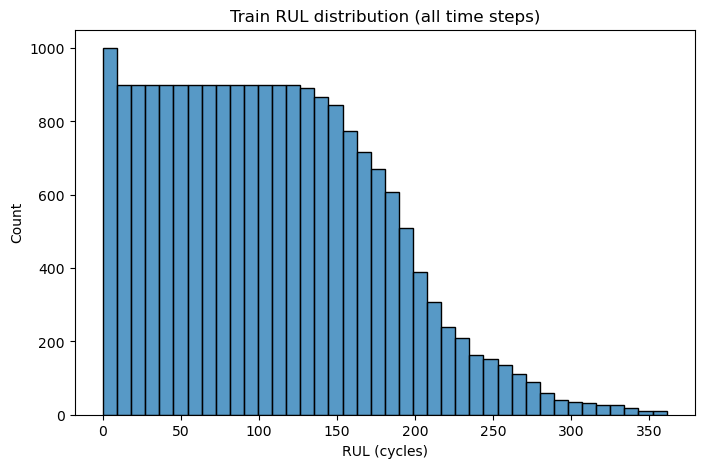

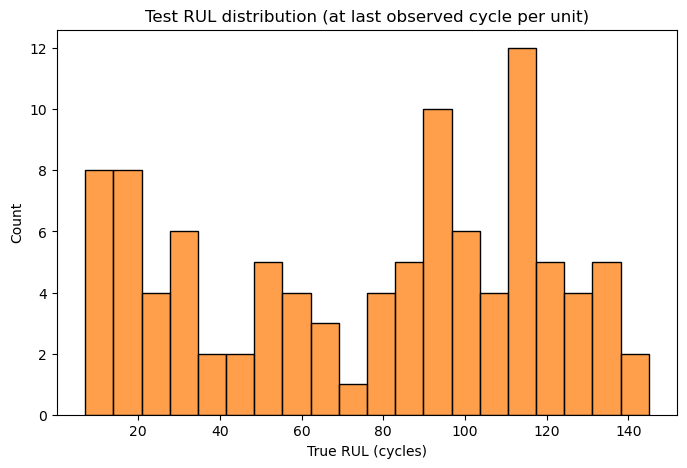

Lowest-variance sensors:
 setting3    0.000000e+00
s19         0.000000e+00
s18         0.000000e+00
s16         2.422479e-28
s10         2.172333e-25
s5          1.152399e-23
s1          4.273435e-21
setting2    8.588541e-08
s6          1.929279e-06
setting1    4.784340e-06
dtype: float64


In [51]:
# RUL distribution (train) — all rows
sns.histplot(train_lbl["RUL"], bins=40)
plt.title("Train RUL distribution (all time steps)"); plt.xlabel("RUL (cycles)"); plt.show()

# True RUL distribution at last observed cycle for each test unit
idx_last_test = test_lbl.groupby("unit")["cycle"].idxmax()
sns.histplot(test_lbl.loc[idx_last_test, "true_RUL"], bins=20, color="tab:orange")
plt.title("Test RUL distribution (at last observed cycle per unit)"); plt.xlabel("True RUL (cycles)"); plt.show()

# Sensor stability quick check — variance per sensor
sensor_cols = [c for c in train_lbl.columns if c.startswith("s")]
var_series = train_lbl[sensor_cols].var().sort_values()
print("Lowest-variance sensors:\n", var_series.head(10))
